# Calculate and plot the number of exchanged messages over time

In [244]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [245]:
pd.set_option("display.precision", 10)
pd.set_option('display.max_rows', 500)

timeframe_upper_limit = 60 # Seconds after startup that you want to look at

### Add path to the dict, use number of nodes as key
It will:
- collect all runs 
- use the key as groupby-column

In [246]:
fanout_to_topo = {
  (2, 2): 7,
  (2, 3): 13,
  (2, 4): 21,
  (2, 8): 73,
  (3, 2): 15,
  (3, 3): 40
}

paths =	[
  "../../logs/maintenance/01-04-2021",
  "../../logs/maintenance/02-04-2021"
]

exclude_paths = ["faulty"]

num_runs = {}

In [247]:
def update_num_runs(topo_run):
    res = {}
    for elem in topo_run:
        if elem[0] in res:
            res[elem[0]] += 1    
        else:
            res[elem[0]] = 1
    
    return res

In [248]:
# m_xxx = maintenance_xxx
# d_xxx = data_xxx
m_stamps = []
m_topologies = []
m_node_ids = []
m_runs = []
m_connect_outliers = []
m_heights = []

d_stamps = []
d_topologies = []
d_node_ids = []
d_runs = []

startup_times = {}

topo_run = []

for path in paths : 
    #print(path)
    for root, dirs, files in os.walk(path) :
        dirs[:] = [directory for directory in dirs if directory not in exclude_paths]
        # print(root)
        # print(dirs)
        # print(files)
        for file in files :
            with open( os.path.join(root, file) ) as log :   
                node_id = file.split('_')[0][4:]              

                connect_attempts = 0                

                split_path = root.split('/')[-2]

                if split_path == '02-04-2021':
                    run = int(root.split('_')[2])
                    fanout = int(root.split('_')[-3])                    
                    height = 3
                    topology = fanout_to_topo[(height, fanout)]
                    
                elif split_path == '01-04-2021':
                    run = int(root.split('_')[2])
                    fanout = int(root.split('_')[-1])                 
                    height = 2
                    topology = fanout_to_topo[(height, fanout)]                    
                
                if (topology, run) not in topo_run:
                    topo_run.append((topology, run))

                for line in log :            
                    if "RECEIVED MESSAGE" in line:
                        # maintencance messages 
                        elem = line.split( )                
                        m_node_ids.append(int(node_id))                        
                        m_stamps.append( int(elem[8]) ) # unix timestamp
                        m_topologies.append(topology)
                        m_runs.append(run)
                        m_heights.append(height)
                    elif "DATA RECEIVED" in line:
                        # data messages
                        pass
                    elif "STARTUP TIME" in line:
                        elem = line.split( )
                        startup_times[topology, run] = int(elem[-1])
                    elif "Try to connect" in line:
                        connect_attempts += 1
                
                if (connect_attempts > 5):
                    m_connect_outliers.append("topology " + str(topology) + " run " + str(run) + " node " + str(node_id))

m_data = pd.DataFrame(np.column_stack([m_topologies, m_runs, m_node_ids, m_stamps]), columns=['topology', 'run', 'node_id', 'timestamp'])
# print(startup_time)
m_data

,topology,run,node_id,timestamp
0,7,4,2,1617283649981429904
1,7,4,2,1617283649981589491
2,7,4,2,1617283649981624437
3,7,4,2,1617283649981634869
4,7,4,2,1617283650216498361
...,...,...,...,...
74756,15,0,9,1617363911078419605
74757,15,0,9,1617363926080275200
74758,15,0,9,1617363926360896671
74759,15,0,9,1617363941362420094


In [249]:
# m_connect_outliers

In [250]:
m_data['topology'].unique()

array([ 7, 13, 73, 21, 15, 40])

In [251]:
num_runs = update_num_runs(topo_run)
num_runs

{7: 11, 13: 11, 73: 6, 21: 10, 15: 10, 40: 8}

In [252]:
m_data['timestamp'] = m_data.apply(lambda row: row.timestamp - startup_times[(row.topology, row.run)], axis=1)
m_data['timestamp_sec'] = m_data['timestamp'].apply(lambda x: x // 1000000000)
m_data

,topology,run,node_id,timestamp,timestamp_sec
0,7,4,2,1834235593,1
1,7,4,2,1834395180,1
2,7,4,2,1834430126,1
3,7,4,2,1834440558,1
4,7,4,2,2069304050,2
...,...,...,...,...,...
74756,15,0,9,20511614111,20
74757,15,0,9,35513469706,35
74758,15,0,9,35794091177,35
74759,15,0,9,50795614600,50


# Reduce timeframe

In [253]:
m_data = m_data[m_data.timestamp_sec <= timeframe_upper_limit]
m_data

,topology,run,node_id,timestamp,timestamp_sec
0,7,4,2,1834235593,1
1,7,4,2,1834395180,1
2,7,4,2,1834430126,1
3,7,4,2,1834440558,1
4,7,4,2,2069304050,2
...,...,...,...,...,...
74756,15,0,9,20511614111,20
74757,15,0,9,35513469706,35
74758,15,0,9,35794091177,35
74759,15,0,9,50795614600,50


# Try to find outliers

In [254]:
m_outliers = m_data.groupby(['topology', 'run', 'node_id', 'timestamp_sec']).size().reset_index(name='number of messages').sort_values(by=['number of messages'], ascending=False, axis=0)
#m_outliers.head()

# Compute results

In [255]:
m_grouped = m_data.groupby(['topology', 'timestamp_sec']).size().reset_index(name='number of messages')
m_grouped['number of messages'] = m_grouped.apply(lambda row: row['number of messages'] / num_runs[row['topology']], axis=1)
m_grouped['number of messages per node'] = m_grouped.apply(lambda row: row['number of messages'] / row['topology'], axis=1)
#m_grouped

# Plot

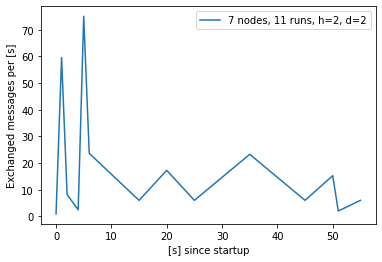

In [256]:
topo_to_plot = 7
height = 2
degree = 2

stepsize=10

ax = plt.gca()
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))

m_grouped[m_grouped['topology'] == topo_to_plot].plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")
plt.legend([str(topo_to_plot) +' nodes, ' + str(num_runs[topo_to_plot]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

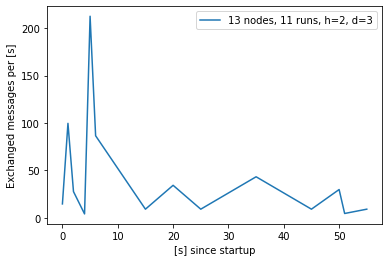

In [257]:
topo_to_plot = 13
height = 2
degree = 3

stepsize=10

ax = plt.gca()
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))

m_grouped[m_grouped['topology'] == topo_to_plot].plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")
plt.legend([str(topo_to_plot) +' nodes, ' + str(num_runs[topo_to_plot]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

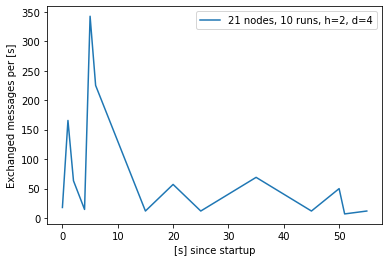

In [258]:
topo_to_plot = 21
height = 2
degree = 4

stepsize=10

ax = plt.gca()
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))

m_grouped[m_grouped['topology'] == topo_to_plot].plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")
plt.legend([str(topo_to_plot) +' nodes, ' + str(num_runs[topo_to_plot]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

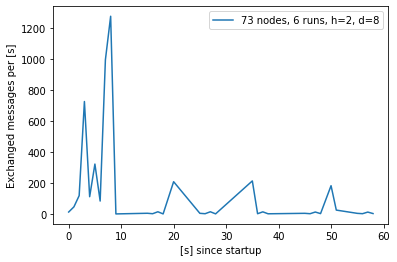

In [259]:
topo_to_plot = 73
height = 2
degree = 8

ax = plt.gca()

m_grouped[m_grouped['topology'] == topo_to_plot].plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")

plt.legend([str(topo_to_plot) +' nodes, ' + str(num_runs[topo_to_plot]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('maintenance-paper-73.pdf')  

# Compute maxima etc.

In [260]:
m_agg_60 = m_grouped[m_grouped['timestamp_sec'] < 60].drop(columns=['timestamp_sec']).groupby(['topology']).sum().reset_index()
m_agg_60['number of messages per second'] = m_agg_60['number of messages'].apply(lambda cell: cell / 60)
m_agg_60['number of messages per node per second'] = m_agg_60['number of messages per node'].apply(lambda cell: cell / 60)
m_agg_60

,topology,number of messages,number of messages per node,number of messages per second,number of messages per node per second
0,7,251.6363636364,35.9480519481,4.1939393939,0.5991341991
1,13,592.1818181818,45.5524475524,9.8696969697,0.7592074592
2,15,700.8000000000,46.7200000000,11.6800000000,0.7786666667
3,21,1060.2000000000,50.4857142857,17.6700000000,0.8414285714
4,40,2650.8750000000,66.2718750000,44.1812500000,1.1045312500
5,73,4443.6666666667,60.8721461187,74.0611111111,1.0145357686


In [261]:
m_agg_20 = m_grouped[m_grouped['timestamp_sec'] < 20].drop(columns=['timestamp_sec']).groupby(['topology']).sum().reset_index()
m_agg_20['number of messages per second'] = m_agg_20['number of messages'].apply(lambda cell: cell / 20)
m_agg_20['number of messages per node per second'] = m_agg_20['number of messages per node'].apply(lambda cell: cell / 20)
m_agg_20

,topology,number of messages,number of messages per node,number of messages per second,number of messages per node per second
0,7,175.8181818182,25.1168831169,8.7909090909,1.2558441558
1,13,453.6363636364,34.8951048951,22.6818181818,1.7447552448
2,15,563.1000000000,37.5400000000,28.1550000000,1.8770000000
3,21,840.9000000000,40.0428571429,42.0450000000,2.0021428571
4,40,2291.6250000000,57.2906250000,114.5812500000,2.8645312500
5,73,3720.6666666667,50.9680365297,186.0333333333,2.5484018265


In [262]:
print('Topology with the maximum number of messages:')
m_agg_60.loc[m_agg_60['number of messages'] == m_agg_60['number of messages'].max()]

Topology with the maximum number of messages:


,topology,number of messages,number of messages per node,number of messages per second,number of messages per node per second
5,73,4443.6666666667,60.8721461187,74.0611111111,1.0145357686


In [263]:
print('Topology with the maximum number of messages per node:')
m_agg_60.loc[m_agg_60['number of messages per node'] == m_agg_60['number of messages per node'].max()]

Topology with the maximum number of messages per node:


,topology,number of messages,number of messages per node,number of messages per second,number of messages per node per second
4,40,2650.875,66.271875,44.18125,1.10453125


# Plot messages per node during startup

In [264]:
m_agg_20

,topology,number of messages,number of messages per node,number of messages per second,number of messages per node per second
0,7,175.8181818182,25.1168831169,8.7909090909,1.2558441558
1,13,453.6363636364,34.8951048951,22.6818181818,1.7447552448
2,15,563.1000000000,37.5400000000,28.1550000000,1.8770000000
3,21,840.9000000000,40.0428571429,42.0450000000,2.0021428571
4,40,2291.6250000000,57.2906250000,114.5812500000,2.8645312500
5,73,3720.6666666667,50.9680365297,186.0333333333,2.5484018265


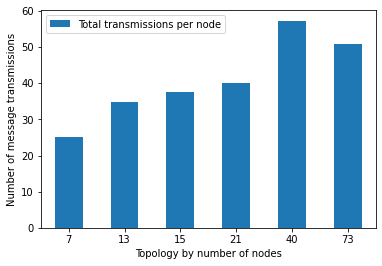

In [270]:
ax = plt.gca()

m_agg_20.plot(kind='bar',x='topology',y='number of messages per node',ax=ax)

plt.xlabel("Topology by number of nodes")
plt.xticks(rotation=0)

plt.ylabel("Number of message transmissions")

plt.legend(['Total transmissions per node'], loc=2)
plt.savefig('maintenance-init-msgs-per-node.pdf')  

# Numbers for movement experiment

In [266]:
# For comparision with movement scenario 
movement_comparison = m_grouped[(m_grouped['timestamp_sec'] >= 31) & (m_grouped['timestamp_sec'] <= 41)].groupby(['topology'])['number of messages'].sum()
# movement_comparison

In [267]:
print('Messages exchanged between 31s,41s: ' + str(movement_comparison) + '\n')

Messages exchanged between 31s,41s: topology
7      23.2727272727
13     43.1818181818
15     43.9000000000
21     69.1000000000
40    116.7500000000
73    233.0000000000
Name: number of messages, dtype: float64



In [268]:
print('Messages exchanged between 31s,41s per node: ' + str(movement_comparison/73))

Messages exchanged between 31s,41s per node: topology
7     0.3188044832
13    0.5915317559
15    0.6013698630
21    0.9465753425
40    1.5993150685
73    3.1917808219
Name: number of messages, dtype: float64
